# Compare openMRG radar and gauges

In [1]:
%matplotlib inline
    
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import wradlib as wrl
from tqdm import tqdm

import opensense_data_downloader_and_transformer as oddt

0.3.0


In [2]:
oddt.download_andersson_2022_OpenMRG(
    local_path="data/andersson_2022_OpenMRG/", print_output=True
)

File already exists at desired location data/andersson_2022_OpenMRG/OpenMRG.zip
Not downloading!


#### Parse rain gauges (city+smhi) and radar to xr.Dataset and resample to 60 min resolution

In [3]:
ds_gauges_city = oddt.transform_andersson_openMRG_city_gauges(
    data_fn="data/andersson_2022_OpenMRG/gauges/city/CityGauges-2015JJA.csv",
    metadata_fn="/pd/home/graf-m/notebooks/cml_method_comparison/gauges/city/CityGauges-metadata.csv")
ds_gauges_city = ds_gauges_city.resample(time='60min').sum()

In [4]:
ds_gauge_smhi = oddt.transform_andersson_openMRG_SMHI_gauge(
    data_fn="data/andersson_2022_OpenMRG/gauges/smhi/GbgA-71420-2015JJA.csv")
ds_gauge_smhi = ds_gauge_smhi.resample(time='60min').sum()

In [5]:
ds_gauges = xr.concat([ds_gauges_city,ds_gauge_smhi], dim='station_id')

In [6]:
ds_radar = oddt.transform_andersson_openMRG_radar(
    data_fn="data/andersson_2022_OpenMRG/radar/radar.nc")
ds_radar = ds_radar.resample(time='60min').mean()

#### First look in data

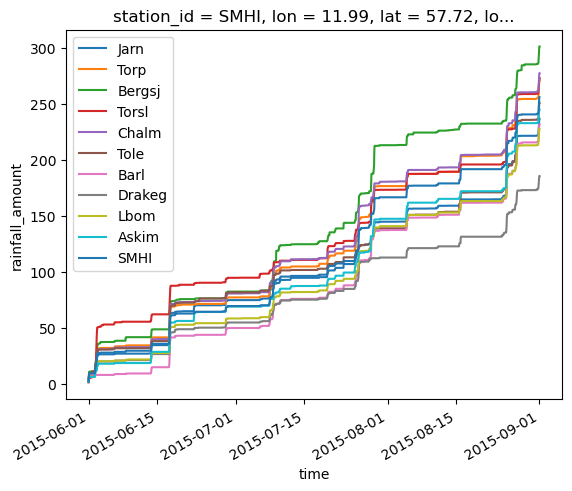

In [7]:
for stat_id in ds_gauges.station_id:
    ds_gauges.sel(station_id=stat_id).rainfall_amount.cumsum().plot(label=str(stat_id.values))
plt.legend();

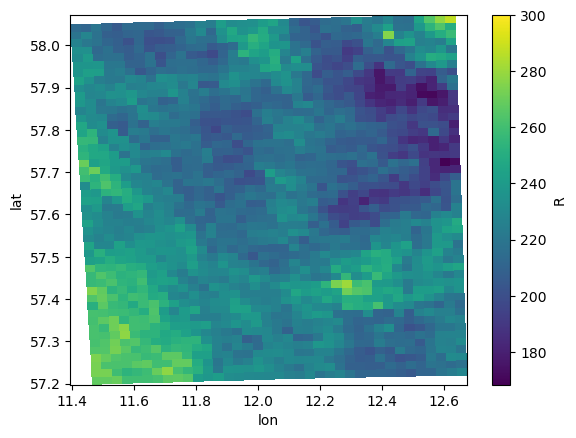

In [8]:
ds_radar.R.sum(dim='time').plot(x='lon',y='lat',vmax=300)

#### Get radar pixel value at each gauge

In [9]:
# gauge coords
x_gauge, y_gauge = oddt.wgs84_to_psp_radolan(
    ds_gauges.lon, ds_gauges.lat
)
xy_gauge = np.array(list(zip(x_gauge.values, y_gauge.values)))

In [10]:
# radar coords
x_radar, y_radar = oddt.wgs84_to_psp_radolan(
    ds_radar.lon, ds_radar.lat)
xy_radar = np.array(list(zip(x_radar.values.flatten(), y_radar.values.flatten())))
# remove smallish radar values and fill nans
ds_radar = ds_radar.where(ds_radar >= 0.01)
ds_radar = ds_radar.fillna(0)

In [11]:
# function to derive point at radar pixel from wradlib
raw_at_obs_adjuster = wrl.adjust.RawAtObs(
    obs_coords=xy_gauge,
    raw_coords=xy_radar,
    nnear=1,
    stat="best",
)

In [12]:
ds_gauges['radar_at_gauge'] = xr.full_like(ds_gauges.rainfall_amount,np.nan)
for i in tqdm(ds_gauges.time):
    ds_gauges['radar_at_gauge'].loc[dict(time=i)][:] = raw_at_obs_adjuster(
        obs=ds_gauges.rainfall_amount.sel(time=i).values,
        raw=ds_radar.R.sel(time=i).values.flatten(),
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2209/2209 [00:05<00:00, 414.76it/s]


#### Evaluate radar at rain gauge location and rain gauge values

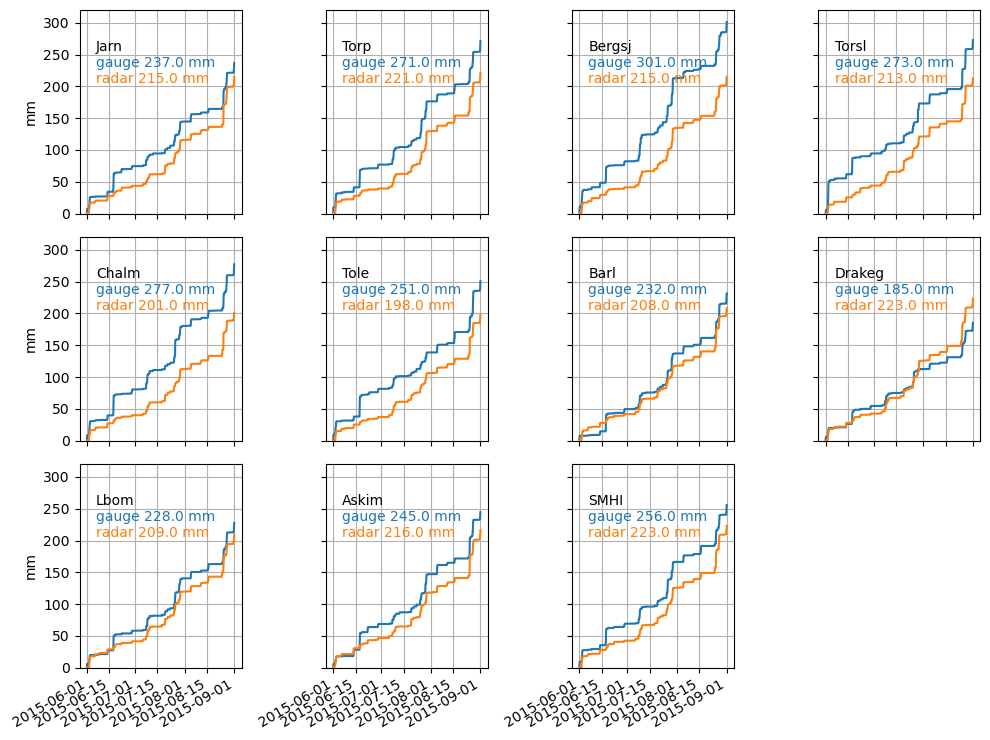

In [13]:
fig, axs = plt.subplots(3, 4, figsize=(10, 7.5), sharex=True,sharey=True)
for i,j,k in zip(range(12),[0,0,0,0,1,1,1,1,2,2,2,2],[0,1,2,3,0,1,2,3,0,1,2,3]):
    plt.sca(axs[j,k])
    if i < 11:
        ds_gauges['rainfall_amount'].isel(station_id=i).cumsum().plot()
        ds_gauges['radar_at_gauge'].isel(station_id=i).cumsum().plot()
        plt.text(0.1,0.8,
             str(ds_gauges.isel(station_id=i).station_id.values),
             transform = axs[j,k].transAxes)
        plt.text(0.1,0.72,
             "gauge "+
             str(np.round(ds_gauges['rainfall_amount'].isel(station_id=i).sum().values))+
             " mm",color="C0",transform = axs[j,k].transAxes)
        plt.text(0.1,0.64,
             "radar "+
             str(np.round(ds_gauges['radar_at_gauge'].isel(station_id=i).sum().values))+
             " mm",color="C1",transform = axs[j,k].transAxes)
        plt.ylim(0,320)
        plt.ylabel('')
        plt.xlabel('')
        plt.title('')
        plt.grid()
    if k == 0:
        plt.ylabel('mm')
    if j == 3:
        plt.xlabel('date')
    if i == 11:
        plt.axis('off')
plt.tight_layout()

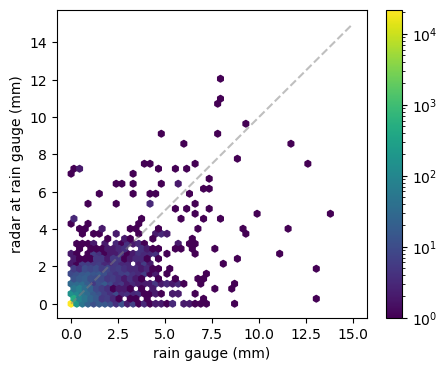

In [14]:
fig,ax=plt.subplots(figsize=(5,4))
plt.hexbin(
    ds_gauges.rainfall_amount.values,
    ds_gauges.radar_at_gauge.values,
    mincnt=1,
    extent=(0,15,0,15),
    bins='log',
    gridsize=50
)
plt.plot([0,15],[0,15],'--',color='grey',alpha=0.5)
plt.xlabel("rain gauge (mm)")
plt.ylabel("radar at rain gauge (mm)")
plt.colorbar();